In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import pymorphy2

import tensorflow as tf
import tensorflow_hub as hub

In [4]:
#!pip install pymorphy2

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
train = pd.read_csv('/content/drive/MyDrive/ML/NLP/предсказание оценки по тексту/train-5.csv')
train.head()

,stars,comment
0,5.0,I taught sections of this book in an undergrad...
1,2.0,This book was required for my undergraduate cl...
2,4.0,Book is really helpful but I cant find equipme...
3,5.0,Enjoyable reading. Recommend to all.
4,5.0,Great book. hard read but great.


In [9]:
test = pd.read_csv('/content/drive/MyDrive/ML/NLP/предсказание оценки по тексту/test-2.csv')
test.head()

,comment
0,"A book that will speak to your head, heart, an..."
1,Very Comprehensive and interesting. Exercises ...
2,"People say that this book is difficult, but I ..."
3,Great book for anyone that is maintaining a we...
4,Good information


In [10]:
train.isnull().sum()

stars      0
comment    0
dtype: int64

In [11]:
test.isnull().sum()

comment    0
dtype: int64

In [12]:
plot = train.groupby('stars', as_index=False)\
     .agg({'comment': 'count'})
plot

,stars,comment
0,1.0,1154
1,2.0,715
2,3.0,1151
3,4.0,2295
4,5.0,11202


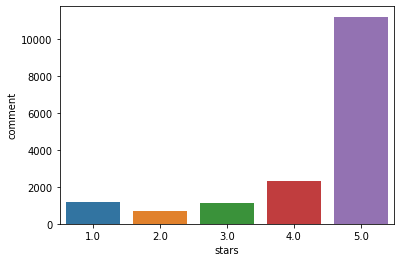

In [13]:
sns.barplot(x='stars', y='comment', data=plot)

In [14]:
train.shape

(16517, 2)

In [15]:
def clean(text):
     text = text.lower()
     text = re.sub(r'\n', '', text)
     return text

In [16]:
train.comment = train.comment.apply(lambda x: clean(x))
test.comment = test.comment.apply(lambda x: clean(x))

In [17]:
ex = nltk.word_tokenize('I taught sections of this book in an undergraduate Ethics of Technology course this year')

In [18]:
train.comment = train.comment.apply(lambda x: nltk.word_tokenize(x))
test.comment = test.comment.apply(lambda x: nltk.word_tokenize(x))

In [19]:
from nltk.corpus import stopwords
def remove_stopwords(text):
     words = [w for w in text if w not in stopwords.words('english')]
     return words

In [20]:
train.comment = train.comment.apply(lambda x: remove_stopwords(x))
test.comment = test.comment.apply(lambda x: remove_stopwords(x))

In [21]:
morph = pymorphy2.MorphAnalyzer()
morph.parse(ex[8])[0].normal_form

'undergraduate'

In [22]:
def lem_word(text):
     return [morph.parse(w)[0].normal_form for w in text]

In [23]:
train.comment = train.comment.apply(lambda x: lem_word(x))
test.comment = test.comment.apply(lambda x: lem_word(x))

In [24]:
def combine_text(list_of_text):
     combine_text = ' '.join(list_of_text)
     return combine_text

In [25]:
train.comment = train.comment.apply(lambda x: combine_text(x))
test.comment = test.comment.apply(lambda x: combine_text(x))

In [26]:
len(train.comment[50])

60

In [29]:
#!pip install tensorflow_text

In [30]:
import tensorflow_text as text

In [31]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def get_sentence_embeding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding(train.comment[50:51])

In [33]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='relu', name="output")(l)

model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [35]:
model.compile(optimizer='adam',
              loss='mean_squared_error')

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train.comment, train.stars, random_state=41, test_size=0.1)

In [43]:
model.fit(X_train, y_train, epochs=25)

Epoch 1/25
465/465 [==============================] - 343s 737ms/step - loss: 1.1224
Epoch 2/25
465/465 [==============================] - 341s 734ms/step - loss: 1.1083
Epoch 3/25
465/465 [==============================] - 341s 733ms/step - loss: 1.1149
Epoch 4/25
465/465 [==============================] - 341s 732ms/step - loss: 1.1210
Epoch 5/25
465/465 [==============================] - 341s 733ms/step - loss: 1.1049
Epoch 6/25
465/465 [==============================] - 340s 732ms/step - loss: 1.1067
Epoch 7/25
465/465 [==============================] - 341s 734ms/step - loss: 1.1196
Epoch 8/25
465/465 [==============================] - 341s 733ms/step - loss: 1.1068
Epoch 9/25
465/465 [==============================] - 341s 733ms/step - loss: 1.1075
Epoch 10/25
465/465 [==============================] - 341s 733ms/step - loss: 1.1072
Epoch 11/25
465/465 [==============================] - 341s 733ms/step - loss: 1.1030
Epoch 12/25
465/465 [==============================] - 341s 733

In [44]:
answer = model.predict(test.comment)

In [45]:
sub = pd.DataFrame(answer, columns=['stars'])

In [47]:
sub.to_csv('/content/drive/MyDrive/ML/NLP/предсказание оценки по тексту/sub_stars133.csv')